# Constructing a Segmentation Pipeline
1. Preprocessing
    - denoising with blur
    - thresholding
    - custom area-based denoising
2. Applying Final Watershed
3. Particle Ananlysis


In [1]:
import cv2 as cv
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os

In [2]:
from augmented_watershed import *

In [3]:
purples = ["#0a0612", "#392249", "#482980", "#673ab7",
           "#7a52aa", "#9779bd", "#b59fd0", "#d3c5e3"]

Importing Image:

In [4]:
source_dir = "/Users/johnmays/Documents/Wirth Lab/convection-cell-research/data/LCB6mil90deg0_frames"
os.chdir(source_dir)
frame1 = cv.imread('frame1.png')
height, width, depth = np.shape(frame1)
frame1_downsized = cv.resize(frame1, (int(width/2), int(height/2)), cv.INTER_AREA) # downsize
frame1_downsized_gray = cv.cvtColor(frame1_downsized,cv.COLOR_BGR2GRAY) # taking one channel

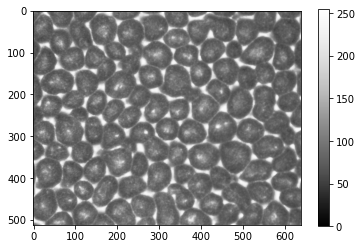

In [5]:
plt.imshow(frame1_downsized_gray, cmap='Greys_r', vmin=0, vmax=255)
plt.colorbar();

### 1. Preprocessing
Small Blur:

In [6]:
frame1_blurred = cv.medianBlur(frame1_downsized_gray, 5)

Thresholding:

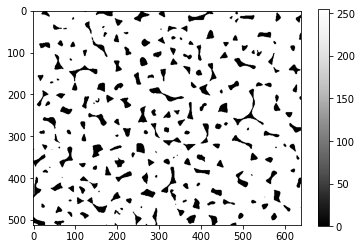

In [8]:
ret, frame1_thresh = cv.threshold(frame1_blurred,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
plt.imshow(frame1_thresh, cmap='Greys_r', vmin=0, vmax=255)
plt.colorbar();

Area-Based Denoising:

In [22]:
frame1_denoised = purgesmallareas(frame1_thresh, 70)

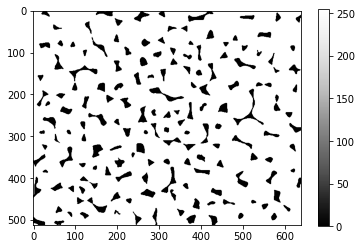

In [23]:
plt.imshow(frame1_denoised, cmap='Greys_r', vmin=0, vmax=255)
plt.colorbar();

Further De-Noising: two possible routes from here:
- situation-based de-noising (watershed distributions)
- shape-based (keep triangles and lines) (with filtering)

In [24]:
def watershed(threshold_image, original_image):
    # takes thresholded image and performs watershed
    thresh = np.copy(threshold_image)
    kernel = np.ones((3,3),np.uint8)
    opening = cv.morphologyEx(thresh,cv.MORPH_OPEN,kernel, iterations = 2)
    sure_bg = cv.dilate(opening,kernel,iterations=3)
    dist_transform = cv.distanceTransform(opening,cv.DIST_L2,5)
    ret, sure_fg = cv.threshold(dist_transform,0.7*dist_transform.max(),255,0)
    sure_fg = np.uint8(sure_fg)
    unknown = cv.subtract(sure_bg,sure_fg)
    ret, markers = cv.connectedComponents(sure_fg)
    markers = markers+1
    markers[unknown==255] = 0
    markers = cv.watershed(original_image,markers)
    original_image[markers == -1] = [255,0,0]

In [25]:
frame1_watershed = watershed(frame1_denoised, frame1_downsized)

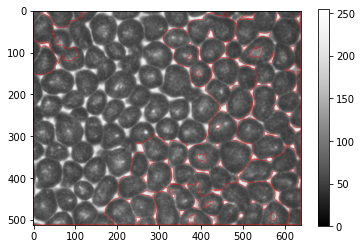

In [27]:
plt.imshow(frame1_downsized, cmap='Greys_r', vmin=0, vmax=255)
plt.colorbar();